In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
%matplotlib inline

import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle

import warnings
warnings.filterwarnings("ignore")


In [2]:
def text_cleaning(text):
    """
    Clean the text using NLP and regular expressions
    
    text = Uncleaned text
    """
    text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
    text = re.sub(r'<.*?>', '', text)
    text = ''.join([char for char in text if char in string.printable])
    text = re.sub(r'@\S+', 'USER', text)
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text


In [3]:
# Fetching reddit data
data = pd.read_csv("Reddit_Data.csv")

# Renaming column
data.rename({'clean_comment':'clean_text'}, axis=1, inplace=True)

# Checking datatypes/shape of data
data.info()

# Checking Statistical Summary of data
data.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  37149 non-null  object
 1   category    37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


,clean_text,category
count,37149,37249.000000
unique,36799,NaN
top,,NaN
freq,115,NaN
mean,NaN,0.202771
std,NaN,0.778515
min,NaN,-1.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Checking null values
print(data.isnull().sum())
print()

# Removing null values
data.dropna(inplace=True)
print(data.isnull().sum())

# Checking duplicated values
print(data.duplicated().sum())
print()

# Removing duplicated values
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())

# Cleaning text using NLP/Regular expression techniques
data["clean_text"] = data["clean_text"].apply(text_cleaning)
data.head()

clean_text    100
category        0
dtype: int64

clean_text    0
category      0
dtype: int64
350

0


,clean_text,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1


In [6]:
mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}
data['category'] = data['category'].map(mapping)
data.head()

,clean_text,category
0,family mormon never tried explain still stare ...,Positive
1,buddhism much lot compatible christianity espe...,Positive
2,seriously say thing first get complex explain ...,Negative
3,learned want teach different focus goal wrappi...,Neutral
4,benefit may want read living buddha living chr...,Positive


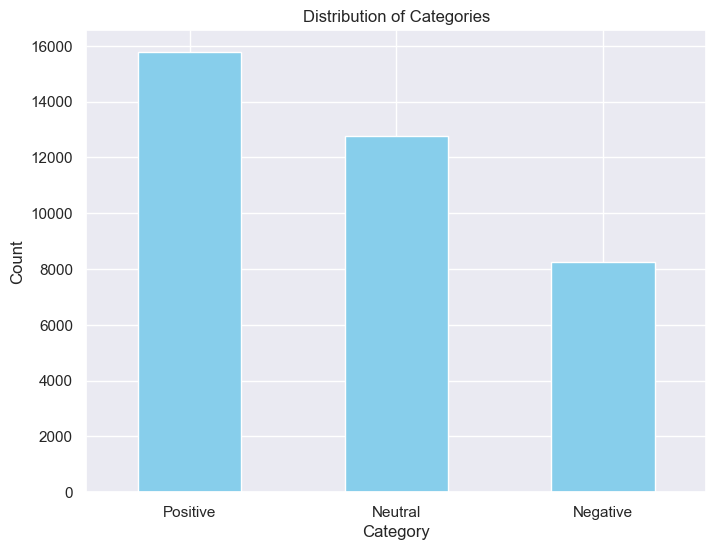

In [7]:
# Checking the distribution of categories
category_counts = data['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

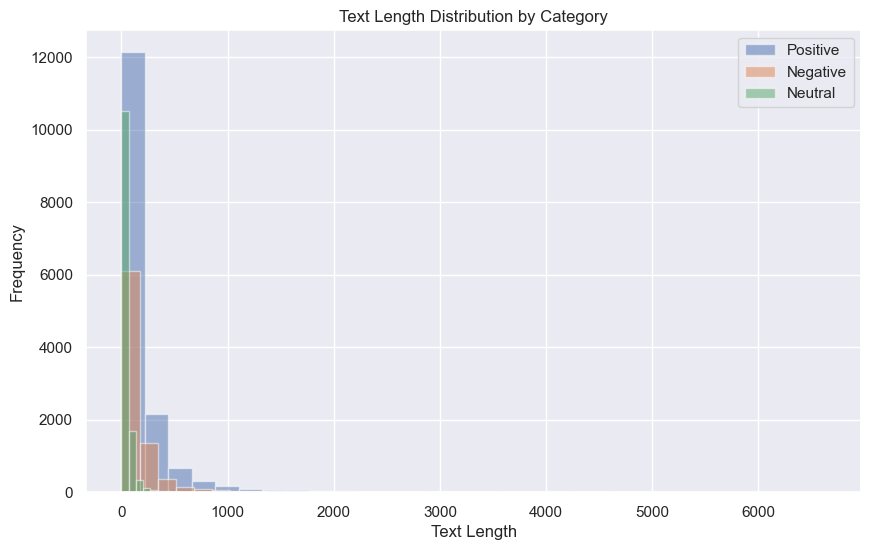

In [8]:

# Performing Text Length Analysis
data['text_length'] = data['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
for category in data['category'].unique():
    subset = data[data['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

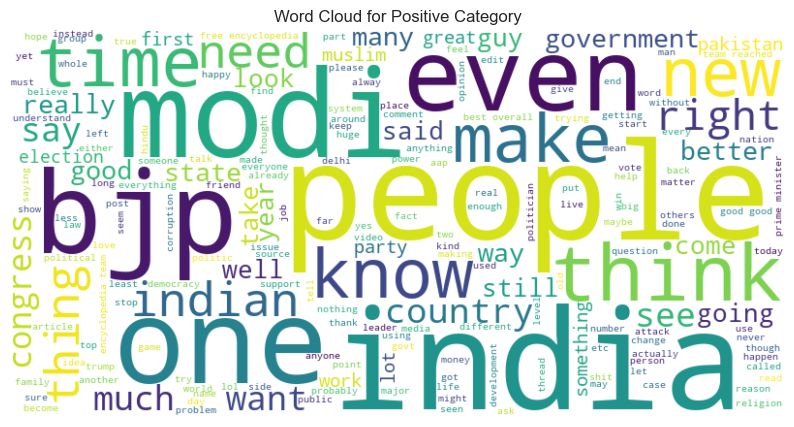

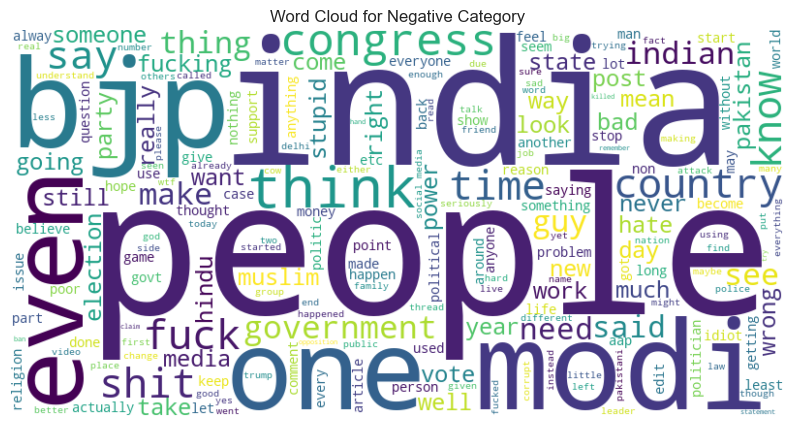

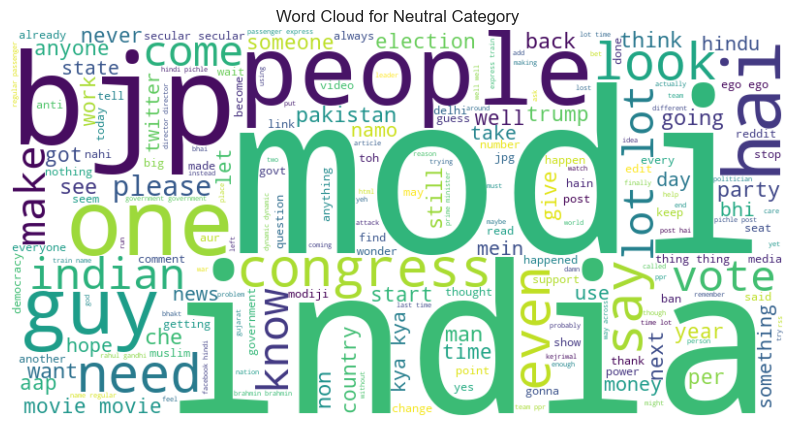

In [9]:
# Creating wordcloud for each category
categories = data['category'].unique()
for category in categories:
    text = " ".join(data[data['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category')
    plt.axis("off")
    plt.show()

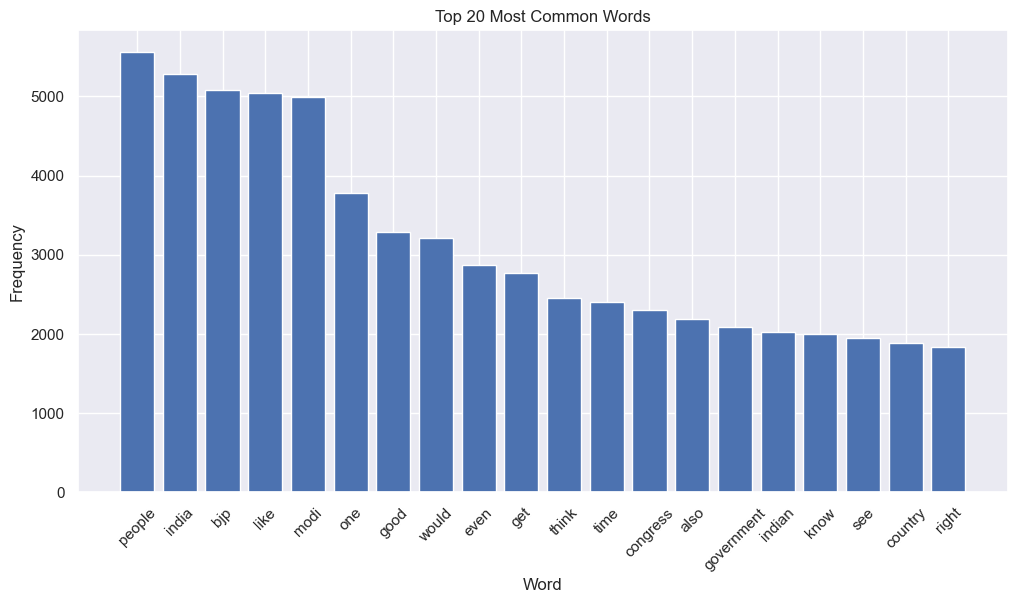

In [10]:
# Calculating Word Frequency 
all_text = " ".join(data['clean_text'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['category'], test_size=0.2, random_state=42)

# Encoding the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")


Class Mapping:
Negative: 0
Neutral: 1
Positive: 2


In [12]:
max_words = 10000  
max_sequence_length = 100  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)

# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


In [13]:
# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 10

# Building the LSTM model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compiling & training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)




Epoch 1/10


414/414 [==============================] - 44s 100ms/step - loss: 0.6748 - accuracy: 0.7155 - val_loss: 0.4351 - val_accuracy: 0.8353
Epoch 2/10
414/414 [==============================] - 40s 96ms/step - loss: 0.3035 - accuracy: 0.9011 - val_loss: 0.3901 - val_accuracy: 0.8716
Epoch 3/10
414/414 [==============================] - 42s 102ms/step - loss: 0.2145 - accuracy: 0.9341 - val_loss: 0.4374 - val_accuracy: 0.8567
Epoch 4/10
414/414 [==============================] - 39s 94ms/step - loss: 0.1766 - accuracy: 0.9472 - val_loss: 0.4816 - val_accuracy: 0.8478
Epoch 5/10
414/414 [==============================] - 38s 92ms/step - loss: 0.1441 - accuracy: 0.9587 - val_loss: 0.5311 - val_accuracy: 0.8461
Epoch 6/10
414/414 [==============================] - 36s 88ms/step - loss: 0.1240 - accuracy: 0.9651 - val_loss: 0.6205 - val_accuracy: 0.8390
Epoch 7/10
414/414 [==============================] - 36s 88ms/step - loss: 0.1075 - accuracy: 0.9703 - val_loss: 0.6414 - val_acc

In [14]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


230/230 [==============================] - 6s 21ms/step - loss: 0.7772 - accuracy: 0.8307
Test Loss: 0.7772
Test Accuracy: 0.8307


In [15]:
y_test_pred = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate additional metrics
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


230/230 [==============================] - 5s 18ms/step
F1 Score: 0.8312
Precision: 0.8318
Recall: 0.8307


In [16]:
# Saving the model to a file
model.save('LSTM.h5')

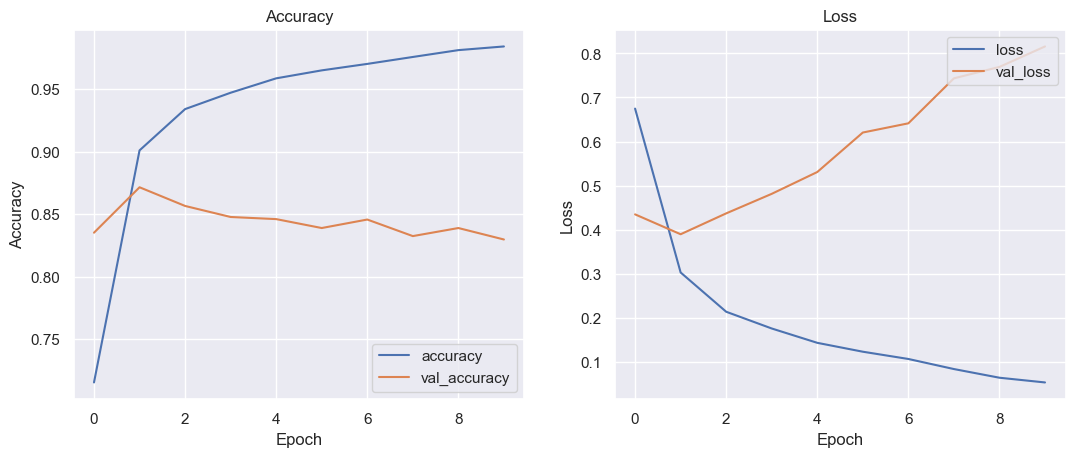

In [17]:
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

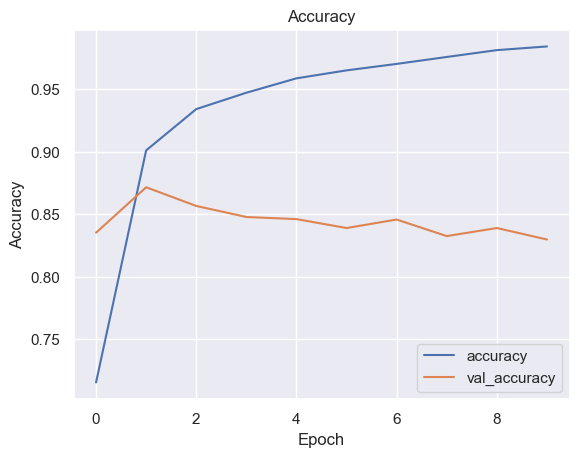

In [19]:
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')         
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

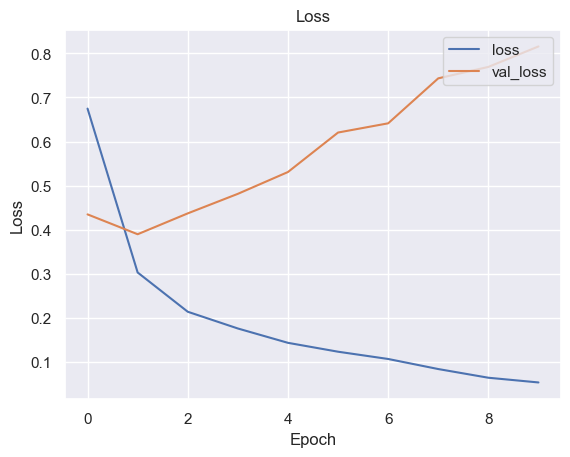

In [20]:
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')         
plt.plot(history.history['val_loss'], label='val_loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [22]:
user_input = "You are very good!!, keep it up"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('LSTM.h5')  
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)
# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)
# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 1s 507ms/step
Predicted Class: Positive


In [24]:
user_input = "You are too bad!!, Shut up"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('LSTM.h5')  
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)
# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)
# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 1s 501ms/step
Predicted Class: Negative


In [25]:
user_input = "How are you??"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('LSTM.h5')  
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)
# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)
# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 1s 542ms/step
Predicted Class: Neutral
